# Fine-Tuning MViT Model on WLASL Dataset

This notebook demonstrates how to fine-tune the MViT on the WLASL dataset for isolated sign language recognition.

In [1]:
#!pip install torch torchvision tqdm

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import pandas as pd
import cv2  
import numpy as np
import re
from torch.nn.utils.rnn import pad_sequence
from torchvision.models.video import mvit_v2_s, MViT_V2_S_Weights

In [159]:
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, split='train', mode='frames', transform=None, max_frames=16, num_classes=100):
        """
        Args:
            root_dir (string): Root directory of the dataset (e.g., "root_directory").
            split (string): One of "train", "val", or "test" to indicate which part of the dataset to load.
            mode (string): Whether to load "sign" or "pose" data.
            transform (callable, optional): Optional transform to be applied on a frame.
            max_frames (int): The maximum number of frames for padding.
            num_classes (int): Number of classes in the dataset.
        """
        self.root_dir = root_dir
        self.split = split  # e.g., 'train', 'val', 'test'
        self.mode = mode  # e.g., 'sign' or 'pose'
        self.transform = transform
        self.max_frames = max_frames  # Maximum number of frames for label padding
        self.num_classes = num_classes  # Total number of classes in the dataset

        self.data = []
        self.labels = {}
        self.rev_labels = {}
        self._load_data()

    def _numerical_sort(self, value):
        # Extract digits from the filename for numerical sorting
        parts = re.findall(r'\d+', value)
        return [int(part) for part in parts]

    def _load_data(self):
        """
        This function traverses the directory structure and loads the paths of the frames.
        It also maps gloss words to labels.
        """
        gloss_word_dir = os.path.join(self.root_dir, self.split, self.mode)

        # Assign labels to each gloss word
        gloss_words = sorted(os.listdir(gloss_word_dir))
        self.labels = {gloss_word: idx for idx, gloss_word in enumerate(gloss_words)}
        self.rev_labels = {idx: gloss_word for idx, gloss_word in enumerate(gloss_words)}
        # Traverse through each gloss word's videos and frames
        for gloss_word in gloss_words:
            gloss_path = os.path.join(gloss_word_dir, gloss_word)

            for video in os.listdir(gloss_path):
                video_path = os.path.join(gloss_path, video)

                # Collect all the frames for the video
                frame_paths = [os.path.join(video_path, frame) for frame in os.listdir(video_path) if frame.endswith('.jpg')]
                frame_paths = sorted(frame_paths, key=self._numerical_sort)  # Ensure frames are loaded in order

                # Add (frames, label) tuple to the dataset
                self.data.append((frame_paths, self.labels[gloss_word]))

    def _generate_labels(self, label, num_frames):
        """
        Generate a label matrix of shape (num_classes, num_frames), 
        where the class for each frame is marked with 1.
        Args:
            label (int): The class label for the video.
            num_frames (int): The number of frames in the video.

        Returns:
            label_matrix (np.ndarray): One-hot encoded label matrix.
        """
        label_matrix = np.zeros((self.num_classes, num_frames), dtype=np.float32)
        for frame_idx in range(num_frames):
            label_matrix[label][frame_idx] = 1
        return label_matrix

    def __len__(self):
        return len(self.data)

    def _crop_center_square(self, frame):
        y, x = frame.shape[0:2]
        min_dim = min(y, x)
        start_x = (x // 3) - (min_dim // 5)
        start_y = (y // 2) - (min_dim // 2)
        return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the data point to return.

        Returns:
            frames (tensor): A tensor containing the frames of the video.
            labels (tensor): One-hot encoded labels for each frame.
        """
        frame_paths, label = self.data[idx]
        frames = []

        # Load each frame, apply transforms, and add to the list
        for frame_path in frame_paths:
            image = Image.open(frame_path).convert('RGB')
            image = np.array(image)
            if self.split == 'val':
                image = self._crop_center_square(image)
            image = Image.fromarray(image)
            if self.transform:
                image = self.transform(image)
            frames.append(image)

        # Stack frames into a tensor of shape (sequence_length, channels, height, width)
        frames = torch.stack(frames)  # (sequence_length, channels, height, width)

        return frames, torch.tensor(label)

In [160]:
train_transforms = transforms.Compose([
    transforms.RandomCrop((224,224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),                   
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),              
    transforms.ToTensor(),                   
])

train_dataset = SignLanguageDataset(root_dir='./preprocessing', split='train', mode='frames', transform=train_transforms)
val_dataset = SignLanguageDataset(root_dir='./preprocessing', split='val', mode='frames', transform=test_transforms)

In [162]:
train_dataset[0][1]

0

In [6]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle=False, drop_last=True)

In [7]:
num_classes = len(train_dataset.labels)
weights = MViT_V2_S_Weights.DEFAULT
model = mvit_v2_s(weights=weights)
model.head = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(model.head[1].in_features, num_classes)
)

In [8]:
#model

In [112]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

In [10]:
patience = 10  
best_val_loss = float('inf')
counter = 0  # Counts epochs without improvement

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 2000

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        videos = videos.permute(0, 2, 1, 3, 4)
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            videos, labels = videos.to(device), labels.to(device)
            videos = videos.permute(0, 2, 1, 3, 4)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    # Calculate metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct * 100) / len(val_dataset)
    scheduler.step(avg_val_loss)

    # Append metrics to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print Metrics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f}%")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model_mvit_run_3_0.00001.pth")
        print(f"Validation loss improved. Model saved.")
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print(f"Early stopping triggered. Training stopped.")
            break

Epoch 1/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]


Epoch 1/2000
Train Loss: 4.6246
Val Loss: 4.5948
Val Accuracy: 1.7804%
Validation loss improved. Model saved.


Epoch 2/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]


Epoch 2/2000
Train Loss: 4.5849
Val Loss: 4.4307
Val Accuracy: 6.5282%
Validation loss improved. Model saved.


Epoch 3/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]


Epoch 3/2000
Train Loss: 4.2159
Val Loss: 3.8888
Val Accuracy: 20.1780%
Validation loss improved. Model saved.


Epoch 4/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]


Epoch 4/2000
Train Loss: 3.7151
Val Loss: 3.4596
Val Accuracy: 23.7389%
Validation loss improved. Model saved.


Epoch 5/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]


Epoch 5/2000
Train Loss: 3.2451
Val Loss: 3.1282
Val Accuracy: 30.2671%
Validation loss improved. Model saved.


Epoch 6/2000 - Validation: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]


Epoch 6/2000
Train Loss: 2.8135
Val Loss: 2.7729
Val Accuracy: 42.7300%
Validation loss improved. Model saved.


Epoch 7/2000 - Validation: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]


Epoch 7/2000
Train Loss: 2.3903
Val Loss: 2.5678
Val Accuracy: 42.7300%
Validation loss improved. Model saved.


Epoch 8/2000 - Validation: 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]


Epoch 8/2000
Train Loss: 2.0132
Val Loss: 2.2231
Val Accuracy: 52.2255%
Validation loss improved. Model saved.


Epoch 9/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]


Epoch 9/2000
Train Loss: 1.6308
Val Loss: 2.0311
Val Accuracy: 54.8961%
Validation loss improved. Model saved.


Epoch 10/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]


Epoch 10/2000
Train Loss: 1.2956
Val Loss: 1.8727
Val Accuracy: 53.1157%
Validation loss improved. Model saved.


Epoch 11/2000 - Validation: 100%|██████████| 42/42 [00:23<00:00,  1.81it/s]


Epoch 11/2000
Train Loss: 1.0036
Val Loss: 1.6085
Val Accuracy: 61.7211%
Validation loss improved. Model saved.


Epoch 12/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]


Epoch 12/2000
Train Loss: 0.7763
Val Loss: 1.5614
Val Accuracy: 62.3145%
Validation loss improved. Model saved.


Epoch 13/2000 - Validation: 100%|██████████| 42/42 [00:23<00:00,  1.81it/s]


Epoch 13/2000
Train Loss: 0.5829
Val Loss: 1.5468
Val Accuracy: 62.0178%
Validation loss improved. Model saved.


Epoch 14/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]


Epoch 14/2000
Train Loss: 0.4352
Val Loss: 1.3776
Val Accuracy: 64.3917%
Validation loss improved. Model saved.


Epoch 15/2000 - Validation: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]


Epoch 15/2000
Train Loss: 0.3461
Val Loss: 1.3629
Val Accuracy: 67.0623%
Validation loss improved. Model saved.


Epoch 16/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]


Epoch 16/2000
Train Loss: 0.2890
Val Loss: 1.3527
Val Accuracy: 66.1721%
Validation loss improved. Model saved.


Epoch 17/2000 - Validation: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]


Epoch 17/2000
Train Loss: 0.2453
Val Loss: 1.3357
Val Accuracy: 66.7656%
Validation loss improved. Model saved.


Epoch 18/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]


Epoch 18/2000
Train Loss: 0.2153
Val Loss: 1.3730
Val Accuracy: 66.4688%
No improvement in validation loss for 1 epoch(s).


Epoch 19/2000 - Validation: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]


Epoch 19/2000
Train Loss: 0.1629
Val Loss: 1.2466
Val Accuracy: 66.7656%
Validation loss improved. Model saved.


Epoch 20/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]


Epoch 20/2000
Train Loss: 0.1234
Val Loss: 1.2854
Val Accuracy: 66.1721%
No improvement in validation loss for 1 epoch(s).


Epoch 21/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]


Epoch 21/2000
Train Loss: 0.1017
Val Loss: 1.3154
Val Accuracy: 68.8427%
No improvement in validation loss for 2 epoch(s).


Epoch 22/2000 - Validation: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]


Epoch 22/2000
Train Loss: 0.1178
Val Loss: 1.4375
Val Accuracy: 67.3591%
No improvement in validation loss for 3 epoch(s).


Epoch 23/2000 - Validation: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]


Epoch 23/2000
Train Loss: 0.1320
Val Loss: 1.6370
Val Accuracy: 59.3472%
No improvement in validation loss for 4 epoch(s).


Epoch 24/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]


Epoch 24/2000
Train Loss: 0.1418
Val Loss: 1.6722
Val Accuracy: 58.4570%
No improvement in validation loss for 5 epoch(s).


Epoch 25/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]


Epoch 25/2000
Train Loss: 0.1118
Val Loss: 1.4519
Val Accuracy: 64.3917%
No improvement in validation loss for 6 epoch(s).


Epoch 26/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]


Epoch 26/2000
Train Loss: 0.0618
Val Loss: 1.3663
Val Accuracy: 65.8754%
No improvement in validation loss for 7 epoch(s).


Epoch 27/2000 - Validation: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]


Epoch 27/2000
Train Loss: 0.0555
Val Loss: 1.3418
Val Accuracy: 66.7656%
No improvement in validation loss for 8 epoch(s).


Epoch 28/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]


Epoch 28/2000
Train Loss: 0.0464
Val Loss: 1.3192
Val Accuracy: 67.3591%
No improvement in validation loss for 9 epoch(s).


Epoch 29/2000 - Validation: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]

Epoch 29/2000
Train Loss: 0.0489
Val Loss: 1.3374
Val Accuracy: 68.8427%
No improvement in validation loss for 10 epoch(s).
Early stopping triggered. Training stopped.


In [11]:
# Save metrics for plotting
import pickle
with open("metrics__mvit_run_3_0.00001.pkl", "wb") as f:
    pickle.dump({"train_loss": train_losses, "val_loss": val_losses, "val_accuracy": val_accuracies}, f)

print("Training complete. Metrics saved for plotting.")

Training complete. Metrics saved for plotting.


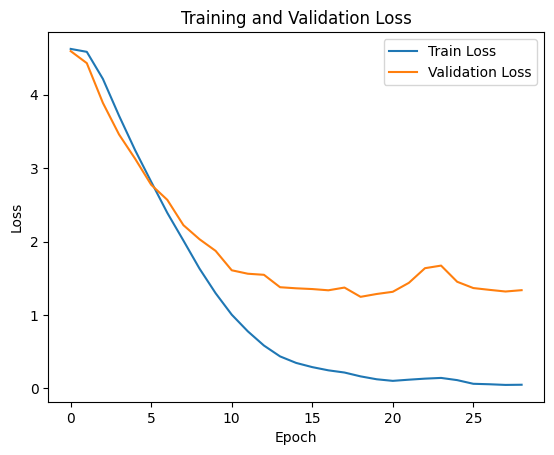

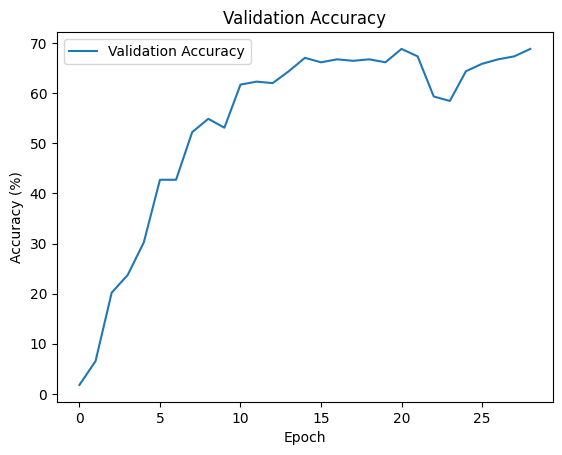

In [12]:
import matplotlib.pyplot as plt
import pickle

# Load metrics
with open("metrics_mvit__run2.pkl", "rb") as f:
    metrics = pickle.load(f)

train_loss = metrics["train_loss"]
val_loss = metrics["val_loss"]
val_accuracy = metrics["val_accuracy"]

# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(val_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


# Testing

In [7]:
num_classes = len(train_dataset.labels)
model = mvit_v2_s(weights=None)
model.head = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(model.head[1].in_features, num_classes)
)

In [13]:
# Load the trained weights
model.load_state_dict(torch.load('best_model_run2.pth'))
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Set the model to evaluation mode
model.eval()
model.to(device)

/tmp/ipykernel_2253693/502729483.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_run2.pth'))


MViT(
  (conv_proj): Conv3d(3, 96, kernel_size=(3, 7, 7), stride=(2, 4, 4), padding=(1, 3, 3))
  (pos_encoding): PositionalEncoding()
  (blocks): ModuleList(
    (0): MultiscaleBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MultiscaleAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (project): Sequential(
          (0): Linear(in_features=96, out_features=96, bias=True)
        )
        (pool_q): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          )
        )
        (pool_k): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 8, 8), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,

In [37]:
test_dataset = SignLanguageDataset(root_dir='./preprocessing', split='test', mode='frames', transform=test_transforms)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=False, drop_last=True)

In [15]:
def top_k_accuracy(output, target, k=5):
    """
    Compute the Top-k accuracy for a given batch of predictions and labels.
    
    Args:
        output (torch.Tensor): Model outputs (logits) with shape (batch_size, num_classes).
        target (torch.Tensor): True labels with shape (batch_size,).
        k (int): The 'k' in Top-k accuracy (default is 5).
    
    Returns:
        int: Number of correct predictions in the top-k.
    """
    # Get the top-k predictions (indices of the largest values)
    top_k_preds = torch.topk(output, k, dim=1).indices  # Shape: (batch_size, k)
    
    # Check if the true label is in the top-k predictions
    correct = top_k_preds.eq(target.unsqueeze(1).expand_as(top_k_preds))
    
    # Return the number of correct predictions
    return correct.sum().item()


In [113]:
all_predictions = []
all_labels = []  # If you need to compare with true labels
val_loss, correct_top1, correct_top5 = 0.0, 0, 0

with torch.no_grad():
    for videos, labels in tqdm(test_loader):
        videos, labels = videos.to(device), labels.to(device)
        videos = videos.permute(0, 2, 1, 3, 4)
        outputs = model(videos)  # Raw logits
        
        # Compute loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        # Compute Top-1 and Top-5 accuracy
        preds = torch.argmax(outputs, dim=1)
        correct_top1 += (preds == labels).sum().item()
        correct_top5 += top_k_accuracy(outputs, labels, k=5) 

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# Average over dataset
top1_accuracy = (correct_top1 / len(test_dataset)) * 100
top5_accuracy = (correct_top5 / len(test_dataset)) * 100        

100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


In [114]:
print(f"Test Loss: {val_loss / len(test_loader):.4f}")
print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

Test Loss: 1.3830
Top-1 Accuracy: 64.73%
Top-5 Accuracy: 87.21%


In [42]:
import numpy as np
def confusion_matrix(y_true, y_pred, num_classes):
    """
    Computes the confusion matrix.
    y_true: Tensor of true labels
    y_pred: Tensor of predicted labels
    num_classes: Number of classes
    """
    # Initialize the confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Populate the confusion matrix
    for t, p in zip(y_true, y_pred):
        confusion_matrix[t, p] += 1
    
    return confusion_matrix

In [43]:
conf_matrix = confusion_matrix(all_labels, all_predictions, num_classes)

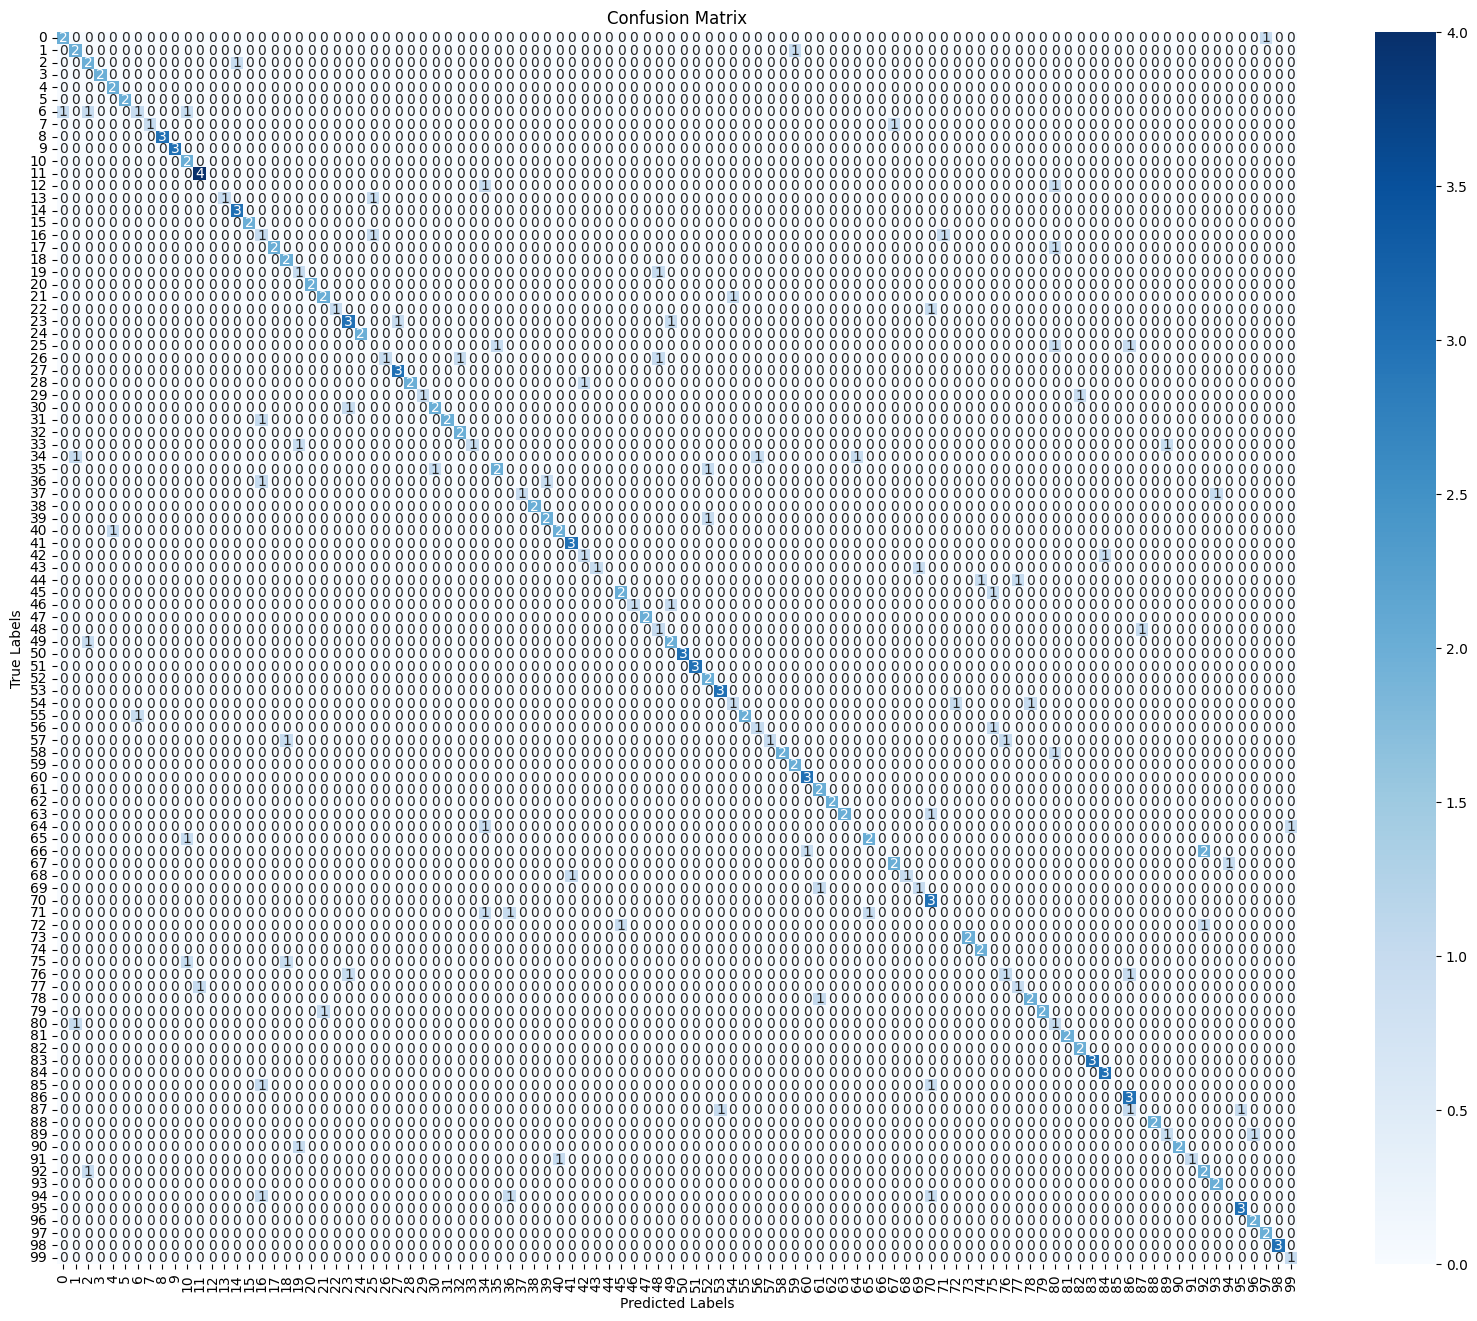

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))

# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=range(100),
            yticklabels=range(100))

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Real time Inference

In [17]:
def compress_frames(frames, target_frames=16):
    compressed = frames[::2]
    
    # If the result exceeds the target, evenly space the compressed frames
    if len(compressed) > target_frames:
        frame_indices = np.linspace(0, len(compressed) - 1, target_frames, dtype=int)
        compressed = [compressed[i] for i in frame_indices]
    
    return torch.stack(compressed)

In [18]:
def _crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 3) - (min_dim // 5)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [19]:

def _extract_frames_from_video(video_path, transform=None):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = _crop_center_square(frame)
        frame = Image.fromarray(frame)
        if transform:
            frame = transform(frame)
        frames.append(frame)
            
    
    cap.release()
    return frames

In [20]:
transformation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),                   
])

In [148]:
frames = _extract_frames_from_video('./test_video/Book.mp4', transformation)

In [156]:
import imageio
from IPython.display import Image as image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    gif_filename = create_gif(video_tensor, gif_name)
    return image(filename=gif_filename)

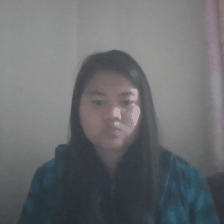

In [157]:
display_gif(compressed_frames, 'book.gif')

In [149]:
compressed_frames = compress_frames(frames)

In [150]:
input_tensor = compressed_frames.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)

In [151]:
outputs = model(input_tensor)  

In [152]:
prediction = torch.argmax(outputs).item()

In [153]:
test_dataset.rev_labels[prediction]

'book'

In [154]:
top_k_preds = torch.topk(outputs, 5, dim=1).indices

In [155]:
top_k_preds

tensor([[11, 38,  6, 68, 22]], device='cuda:1')

In [29]:
test_dataset.labels

{'accident': 0,
 'africa': 1,
 'all': 2,
 'apple': 3,
 'basketball': 4,
 'bed': 5,
 'before': 6,
 'bird': 7,
 'birthday': 8,
 'black': 9,
 'blue': 10,
 'book': 11,
 'bowling': 12,
 'brown': 13,
 'but': 14,
 'can': 15,
 'candy': 16,
 'chair': 17,
 'change': 18,
 'cheat': 19,
 'city': 20,
 'clothes': 21,
 'color': 22,
 'computer': 23,
 'cook': 24,
 'cool': 25,
 'corn': 26,
 'cousin': 27,
 'cow': 28,
 'dance': 29,
 'dark': 30,
 'deaf': 31,
 'decide': 32,
 'doctor': 33,
 'dog': 34,
 'drink': 35,
 'eat': 36,
 'enjoy': 37,
 'family': 38,
 'fine': 39,
 'finish': 40,
 'fish': 41,
 'forget': 42,
 'full': 43,
 'give': 44,
 'go': 45,
 'graduate': 46,
 'hat': 47,
 'hearing': 48,
 'help': 49,
 'hot': 50,
 'how': 51,
 'jacket': 52,
 'kiss': 53,
 'language': 54,
 'last': 55,
 'later': 56,
 'letter': 57,
 'like': 58,
 'man': 59,
 'many': 60,
 'medicine': 61,
 'meet': 62,
 'mother': 63,
 'need': 64,
 'no': 65,
 'now': 66,
 'orange': 67,
 'paint': 68,
 'paper': 69,
 'pink': 70,
 'pizza': 71,
 'play': 72